In [25]:
import os  # 用於文件操作
import cv2  # 用於影像處理
import math  # 用於數學運算
import numpy as np  # 用於數值運算
import pandas as pd  # 用於數據處理
import joblib  # 用於保存和加載資料縮放器
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt  # 用於繪圖
from datetime import datetime  # 用於時間操作
from sklearn.preprocessing import MinMaxScaler  # 用於資料縮放
import matplotlib.font_manager as fm

import tensorflow as tf  # 深度學習框架
from tensorflow.keras import backend as K  # 用於自定義損失函數
jheng_hei_b_font = fm.FontProperties(fname=r'fonts\微軟正黑體_粗體.ttc')
jheng_hei_font = fm.FontProperties(fname=r'fonts\微軟正黑體_標準.ttc')

In [26]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [27]:
SPLIT_DATA_MODE = 'month'  # 'month' or 'sequence' or 'old_dataset'

HIGHT = WIDTH = 224
LATITUDE = 'Latitude'
LONGITUDE = 'Longitude'
CHANNELS = 1
WINDOW_SIZE = 2
STEP_SIZE = 1

SCALER_PATH = rf'config\{SPLIT_DATA_MODE}\lstm_multitask_scaler.gz'

if SPLIT_DATA_MODE == 'month':
    # MODEL_PATH = r'weights\month\multimodal_multitask_output-level_fusion\concat\multimodal_mt_diff2-1_e03v0.0006'
    # MODEL_PATH = r'weights\month\multimodal_multitask_output-level_fusion\average\multimodal_mt_diff2-1_e09v0.0006'
    # MODEL_PATH = r'weights\month\multimodal_multitask_output-level_fusion\gate\multimodal_mt_diff2-1_e08v0.0006'
    MODEL_PATH = r'weights\month\multimodal_multitask_output-level_fusion\attention\multimodal_mt_diff2-1_e15v0.0006'

In [28]:
# # ============= 均方根誤差 =============
# def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     return K.sqrt(K.mean(K.square(y_pred - y_true)))
# def load_model(model_path: str, custom_objects: dict = None) -> tf.keras.models.Model:
#     if custom_objects is None:
#         return tf.keras.models.load_model(model_path)
#     return tf.keras.models.load_model(model_path, custom_objects=custom_objects)
# model = load_model(model_path=MODEL_PATH, custom_objects={'rmse': rmse})
# model.summary()

In [29]:
# ============= 均方根誤差 =============
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ============= 計算格點資料差分 =============
def radar_grid_diff_processing(radar_grids: np.ndarray) -> np.ndarray:
    diff_radar_grids = []
    for i in range(len(radar_grids) - 1):
        radar_grid_diff = cv2.absdiff(radar_grids[i + 1], radar_grids[i])
        diff_radar_grids.append(radar_grid_diff)
    return np.expand_dims(np.array(diff_radar_grids), axis=-1)

# ============= 讀取模型 =============
def load_model(model_path: str, custom_objects: dict = None) -> tf.keras.models.Model:
    if custom_objects is None:
        return tf.keras.models.load_model(model_path)
    return tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# ============= 讀取scaler =============
def load_scaler(scaler_path: str) -> joblib.load:
    return joblib.load(scaler_path)

# ============= 確保雷達與cell資料對應 =============
def get_cell_dataset(radar_folders : list) -> list:
    def make_csv_paths(radar_files : list) -> list:
        return [os.path.basename(f) + '.csv' for f in radar_files]
    
    cell_files = make_csv_paths(radar_folders)
    return cell_files    

# ============= 讀取資料 =============
def read_data(case_name: str, scaler: MinMaxScaler) -> tuple:
    cell_data_path = rf'data\{case_name}\cells'
    radar_data_path = rf'data\{case_name}\radar_grids'

    cell_files = sorted(os.listdir(cell_data_path))
    radar_folders = sorted(os.listdir(radar_data_path))

    # 原始數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的數值序列
    dataset = []
    # 差分數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的差分數值序列
    diff_dataset = []
    #LSMT 輸入資料(差分數值資料)
    lstm_input_dataset = []
    # ConvLSTM 輸入資料(差分數值資料)
    convlstm_input_dataset = []

    for cell_file, radar_folder in zip(cell_files, radar_folders):
        if cell_file.endswith('.joblib') or radar_folder.endswith('.joblib'):
            continue

        cell_file_path = os.path.join(cell_data_path, cell_file)
        radar_folder_path = os.path.join(radar_data_path, radar_folder)

        # ============= 處理單一個數值序列資料 =============
        # 讀取CSV數據並計算差值
        # print(cell_file_path)
        cell_data = pd.read_csv(cell_file_path, encoding='utf-8',
                                dtype={'fileName': str, 'day': str, 'time': str})

        if len(cell_data) < 4: # 至少需要4筆資料才能計算差分(含預測)
            continue

        # 計算經緯度差分
        data_diff = cell_data[[LATITUDE, LONGITUDE]
                              ].diff().dropna().reset_index(drop=True)

        # 提取經度和緯度差值
        lat_diff = cell_data[LATITUDE].diff().dropna().reset_index(drop=True)
        lng_diff = cell_data[LONGITUDE].diff().dropna().reset_index(drop=True)

        combined_data = np.vstack([lat_diff.values, lng_diff.values]).T  # 經緯度差異合併

        # 使用scaler對資料進行縮放
        scaled_data_diff = scaler.transform(combined_data)

        # ============= 處理單一個雷達序列資料 =============
        radars = []
        radar_names = sorted(os.listdir(radar_folder_path))
        for radar_name in radar_names:
            radar_path = os.path.join(radar_folder_path, radar_name)
            radar = np.load(radar_path)
            radar_resized = cv2.resize(radar, (HIGHT, WIDTH))
            radars.append(radar_resized)

        # 計算雷達圖片差分
        diff_radars = radar_grid_diff_processing(np.array(radars))

        dataset.append(cell_data)
        diff_dataset.append(data_diff)
        lstm_input_dataset.append(scaled_data_diff)
        convlstm_input_dataset.append(diff_radars)

    return (dataset, diff_dataset, lstm_input_dataset, convlstm_input_dataset)

In [30]:
# ============= 預測路徑 =============
def predict_path(model: tf.keras.models.Model, dataset_components: tuple) -> np.array:
    dataset, diff_dataset, lstm_input_dataset, convlstm_input_dataset = dataset_components

    diff_pred_dict = {}  # 用經緯度差分預測結果
    diff_true_dict = {}  # 用經緯度差分真實結果

    for i, data in enumerate(dataset):

        diff_pred = []  # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]
        diff_true = []  # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]

        for j in range(0, len(convlstm_input_dataset[i]) - WINDOW_SIZE, STEP_SIZE):
            # 準備 LSTM 和 ConvLSTM 輸入數據
            lstm_input = np.expand_dims(
                np.array(lstm_input_dataset[i][j: j+WINDOW_SIZE], dtype=np.float32), axis=0)
            convlstm_input = np.expand_dims(
                np.array(convlstm_input_dataset[i][j: j+WINDOW_SIZE], dtype=np.float32), axis=0)
            
            input_data = {'lstm_input': lstm_input, 'convlstm_input': convlstm_input}

            # 預測經緯度差分
            lat_pred, lng_pred = model.predict(input_data)

            # 獲取真實經緯度差分
            true_lat = diff_dataset[i][LATITUDE].values[j+WINDOW_SIZE]
            true_lng = diff_dataset[i][LONGITUDE].values[j+WINDOW_SIZE]

            diff_pred.append((lat_pred.item(), lng_pred.item()))
            diff_true.append((true_lat, true_lng))

        diff_pred_dict[i] = diff_pred
        diff_true_dict[i] = diff_true

    return dataset, diff_pred_dict, diff_true_dict

In [31]:
def plot_path(dataset: list, pred_dict: dict) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())  # 經緯度座標系

    # =================== 統計所有經緯度的最大最小值 ===================
    all_lats = []
    all_lngs = []

    for i, data in enumerate(dataset):
        lats = np.array(data[LATITUDE])
        lngs = np.array(data[LONGITUDE])
        all_lats.extend(lats)
        all_lngs.extend(lngs)

        for pred in pred_dict[i]:
            pred_lat, pred_lng = pred
            all_lats.append(pred_lat)
            all_lngs.append(pred_lng)

    min_lat, max_lat = min(all_lats), max(all_lats)
    min_lng, max_lng = min(all_lngs), max(all_lngs)

    # =================== 繪圖開始 ===================
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 設定經緯度邊界，加 buffer
    lat_buffer = (max_lat - min_lat) * 0.05
    lng_buffer = (max_lng - min_lng) * 0.05
    # ax.set_extent([min_lng - lng_buffer, max_lng + lng_buffer,
    #                min_lat - lat_buffer, max_lat + lat_buffer], crs=ccrs.PlateCarree())

    # '梅雨鋒面個案_2021-05-30'
    # ax.set_extent([119.8001659, 123.8208661, 23.81446730319214, 26.75911663296509], crs=ccrs.PlateCarree())
    # min_lat, max_lat = 23.45, 26.5
    # min_lng, max_lng = 119.8, 123.8

    # '午後對流個案_2022-08-25'
    # min_lat, max_lat = 23.25, 25.75
    # min_lng, max_lng = 119.75, 122.5
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # print(f'設定經緯度範圍: {extent}')
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    # '烟花颱風個案_2021-07-22'
    min_lat, max_lat = 22.75, 27.45
    min_lng, max_lng = 120.15, 124.15
    extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    print(f'設定經緯度範圍: {extent}')
    ax.set_extent(extent, crs=ccrs.PlateCarree())


    # 設定 X、Y 軸刻度（每隔 0.5 度一格可調整）
    x_ticks = np.round(np.arange(min_lng, max_lng + 0.1, 0.5), 2)
    y_ticks = np.round(np.arange(min_lat, max_lat + 0.1, 0.5), 2)
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)

    # 可選：顯示經緯度刻度線
    ax.gridlines(draw_labels=False, linewidth=0.5,
                 color='gray', alpha=0.5, linestyle='--')

    # =================== 畫實際與預測軌跡 ===================
    for i, data in enumerate(dataset):
        latitudes = list(np.array(data[LATITUDE]))
        longitudes = list(np.array(data[LONGITUDE]))

        # 差分轉回原始資料 --------------------------------------------------------------
        pred_latitudes = []
        pred_longitudes = []
        # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]
        for j, diff_pred in enumerate(diff_pred_dict[i]):
            pred_lat = diff_pred[0] + latitudes[j + WINDOW_SIZE]
            pred_lng = diff_pred[1] + longitudes[j + WINDOW_SIZE]
            pred_latitudes.append(pred_lat)
            pred_longitudes.append(pred_lng)

        plt.plot(longitudes, latitudes, marker='o',
                 markersize=1.5, color='#1f77b4', linewidth=.5)
        plt.plot(pred_longitudes, pred_latitudes, marker='o',
                 markersize=1.5, color='#ff7f0e', linewidth=.5)

    plt.legend(['真實路徑', '預測路徑'], prop=jheng_hei_font, fontsize=8)
    # plt.title(f'LSTM 預測路徑', fontproperties=jheng_hei_b_font, fontsize=14)
    plt.xlabel('經度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.ylabel('緯度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.tight_layout()
    plt.show()

In [32]:
import math
from haversine import haversine

# ============= 計算誤差(公里) =============
def calculate_mae_distance(lat_mae: float, lon_mae: float, latitude: float = 25.071182):
    lat_km = lat_mae * 111
    lon_km = lon_mae * 111 * math.cos(math.radians(latitude))
    return math.sqrt(lat_km**2 + lon_km**2)

# ============= 評估主函式 =============
def evaluate(dataset: list, pred_dict: dict, true_dict: dict) -> None:
    # ===== 實際位置誤差（預測差加回原始位置） =====
    lat_errors = []
    lng_errors = []
    distances = []

    for i, data in enumerate(dataset):
        latitudes = np.array(data[LATITUDE])
        longitudes = np.array(data[LONGITUDE])

        for j, diff_pred in enumerate(pred_dict[i]):
            pred_lat = diff_pred[0] + latitudes[j + WINDOW_SIZE]
            pred_lng = diff_pred[1] + longitudes[j + WINDOW_SIZE]
            real_lat = latitudes[j + (WINDOW_SIZE + 1)]
            real_lng = longitudes[j + (WINDOW_SIZE + 1)]

            error_lat = abs(real_lat - pred_lat)
            error_lng = abs(real_lng - pred_lng)
            lat_errors.append(real_lat - pred_lat)
            lng_errors.append(real_lng - pred_lng)

            distances.append(haversine((real_lat, real_lng), (pred_lat, pred_lng)))

    lat_errors = np.array(lat_errors)
    lng_errors = np.array(lng_errors)

    lat_mae_pos = np.mean(np.abs(lat_errors))
    lng_mae_pos = np.mean(np.abs(lng_errors))
    lat_mse_pos = np.mean(lat_errors**2)
    lng_mse_pos = np.mean(lng_errors**2)
    lat_rmse_pos = np.sqrt(lat_mse_pos)
    lng_rmse_pos = np.sqrt(lng_mse_pos)
    avg_distance = np.mean(distances)

    print("=== 經緯度位置（還原後）評估 ===")
    print(f'Latitude MSE: {lat_mse_pos:.6f}')
    print(f'Longitude MSE: {lng_mse_pos:.6f}')
    print(f'Latitude MAE: {lat_mae_pos:.6f} 度')
    print(f'Longitude MAE: {lng_mae_pos:.6f} 度')
    print(f'Latitude RMSE: {lat_rmse_pos:.6f}')
    print(f'Longitude RMSE: {lng_rmse_pos:.6f}')
    print(f'Average Haversine distance error: {avg_distance:.6f} km')

--------------模型讀取成功--------------
1/1 [==============================] - 0s 21ms/step
=== 經緯度位置（還原後）評估 ===
Latitude MSE: 0.001295
Longitude MSE: 0.001321
Latitude MAE: 0.032126 度
Longitude MAE: 0.021556 度
Latitude RMSE: 0.035993
Longitude RMSE: 0.036346
Average Haversine distance error: 4.613904 km
設定經緯度範圍: [120.15, 124.15, 22.75, 27.45]


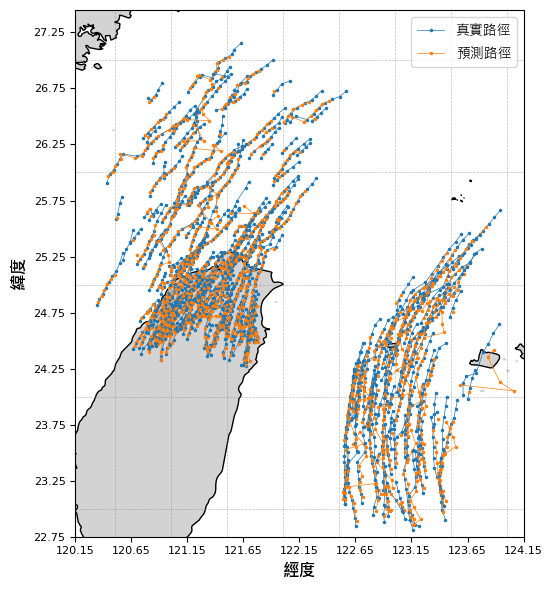

In [37]:
# ===================================
# 2021-01-16  冬季降雨個案(不太好看)
# start_date = '2021-01-16 06:00:00'
# end_date = '2021-01-16 12:00:00'
# 2021-05-30  梅雨鋒面個案
# start_date = '2021-05-30 04:00:00'
# end_date = '2021-05-30 10:00:00'
# 2022-08-25  午後對流個案(很短很小)
# start_date = '2022-08-25 05:00:00'
# end_date = '2022-08-25 11:00:00'
# 2021-07-22  烟花颱風個案(先不要)
# start_date = '2021-07-22 06:00:00'
# end_date = '2021-07-22 12:00:00'
# 2022-09-04  軒嵐諾颱風
# start_date = '2022-09-04 11:00:00'
# end_date = '2022-09-04 17:00:00'
# ===================================

# case_name = '梅雨鋒面個案_2021-05-30'
# case_name = '午後對流個案_2022-08-25'
case_name = '烟花颱風個案_2021-07-22'

# 讀取模型
model = load_model(model_path=MODEL_PATH, custom_objects={'rmse': rmse})
# 列印模型結構
# print(model.summary())

print('--------------模型讀取成功--------------')

# 讀取資料縮放器
scaler = load_scaler(scaler_path=SCALER_PATH)

# 讀取資料(原始數值資料，差分數值資料，LSTM輸入數據，ConvLSTM輸入數據)
dataset_components = read_data(
    case_name=case_name,
    scaler=scaler
)


# 預測差分路徑
dataset, diff_pred_dict, diff_true_dict = predict_path(
    model=model, dataset_components=dataset_components)

# 評估模型
evaluate(dataset, diff_pred_dict, diff_true_dict)

# 繪製預測路徑與真實路徑
plot_path(dataset, diff_pred_dict)

In [34]:
from pyproj import Proj, Transformer

def xy_km_to_latlon_aeqd(x_km, y_km, center_lat=25.073, center_lon=121.772003):
    proj_local = Proj(proj='aeqd', lat_0=center_lat, lon_0=center_lon,
                      ellps='WGS84', units='m', no_defs=True)
    transformer = Transformer.from_proj(proj_local, "epsg:4326", always_xy=True)

    x_m = np.asarray(x_km) * 1000
    y_m = np.asarray(y_km) * 1000
    lons, lats = transformer.transform(x_m, y_m)
    return lons, lats


def add_scit_prediction_path(data, forecast_seconds=360):
    # ==== 原始 UMotion / VMotion ====
    u_motion = data['UMotion'].copy()
    v_motion = data['VMotion'].copy()

    # ==== 轉位移距離 ====
    dx = u_motion * forecast_seconds  # 公里
    dy = v_motion * forecast_seconds

    pred_x_km = data['3DXLoc'] + dx
    pred_y_km = data['3DYLoc'] + dy

    # ==== 座標轉換 ====
    pred_lon, pred_lat = xy_km_to_latlon_aeqd(pred_x_km, pred_y_km)

def create_scit_predict_path(dataset: list, forecast_seconds=360) -> pd.DataFrame:

    scit_dataset = []
    for i, data in enumerate(dataset):
        df = data.copy()

        # ==== 原始 UMotion / VMotion ====
        u_motion = df['UMotion']
        v_motion = df['VMotion']

        # ==== 轉位移距離 ====
        dx = u_motion * forecast_seconds  # 公里
        dy = v_motion * forecast_seconds

        pred_x_km = data['3DXLoc'] + dx
        pred_y_km = data['3DYLoc'] + dy

        # ==== 座標轉換 ====
        pred_lon, pred_lat = xy_km_to_latlon_aeqd(pred_x_km, pred_y_km)

        df['Pred_Latitude'] = pred_lat
        df['Pred_Longitude'] = pred_lon

        scit_dataset.append(df)
        
        # print('#' * 30)
        # print(df)
        # break

    return scit_dataset

scit_dataset = create_scit_predict_path(dataset, forecast_seconds=360)


In [35]:
# ============= 評估主函式 =============
def scit_evaluate(dataset: list) -> None:
    # ===== 實際位置誤差（預測差加回原始位置） =====
    lat_errors = []
    lng_errors = []
    distances = []

    for i, data in enumerate(dataset):
        latitudes = np.array(data[LATITUDE])
        longitudes = np.array(data[LONGITUDE])

        pred_latitudes = np.array(data['Pred_Latitude'][2:-1])
        pred_longitudes = np.array(data['Pred_Longitude'][2:-1])

        for j, (pred_lat, pred_lng) in enumerate(zip(pred_latitudes, pred_longitudes)):
            real_lat = latitudes[j + (WINDOW_SIZE + 1)]
            real_lng = longitudes[j + (WINDOW_SIZE + 1)]

            error_lat = abs(real_lat - pred_lat)
            error_lng = abs(real_lng - pred_lng)
            lat_errors.append(real_lat - pred_lat)
            lng_errors.append(real_lng - pred_lng)

            distances.append(haversine((real_lat, real_lng), (pred_lat, pred_lng)))

        # for j, diff_pred in enumerate(pred_dict[i]):
        #     pred_lat = diff_pred[0] + latitudes[j + WINDOW_SIZE]
        #     pred_lng = diff_pred[1] + longitudes[j + WINDOW_SIZE]
        #     real_lat = latitudes[j + (WINDOW_SIZE + 1)]
        #     real_lng = longitudes[j + (WINDOW_SIZE + 1)]

        #     error_lat = abs(real_lat - pred_lat)
        #     error_lng = abs(real_lng - pred_lng)
        #     lat_errors.append(real_lat - pred_lat)
        #     lng_errors.append(real_lng - pred_lng)

        #     distances.append(haversine((real_lat, real_lng), (pred_lat, pred_lng)))

    lat_errors = np.array(lat_errors)
    lng_errors = np.array(lng_errors)

    lat_mae_pos = np.mean(np.abs(lat_errors))
    lng_mae_pos = np.mean(np.abs(lng_errors))
    lat_mse_pos = np.mean(lat_errors**2)
    lng_mse_pos = np.mean(lng_errors**2)
    lat_rmse_pos = np.sqrt(lat_mse_pos)
    lng_rmse_pos = np.sqrt(lng_mse_pos)
    avg_distance = np.mean(distances)

    print("=== 經緯度位置（還原後）評估 ===")
    print(f'Latitude MSE: {lat_mse_pos:.6f}')
    print(f'Longitude MSE: {lng_mse_pos:.6f}')
    print(f'Latitude MAE: {lat_mae_pos:.6f} 度')
    print(f'Longitude MAE: {lng_mae_pos:.6f} 度')
    print(f'Latitude RMSE: {lat_rmse_pos:.6f}')
    print(f'Longitude RMSE: {lng_rmse_pos:.6f}')
    print(f'Average Haversine distance error: {avg_distance:.6f} km')

# SCIT 預測路徑可視化

=== 經緯度位置（還原後）評估 ===
Latitude MSE: 0.000367
Longitude MSE: 0.000298
Latitude MAE: 0.013433 度
Longitude MAE: 0.012336 度
Latitude RMSE: 0.019163
Longitude RMSE: 0.017268
Average Haversine distance error: 2.156432 km
設定經緯度範圍: [120.15, 124.15, 22.75, 27.45]


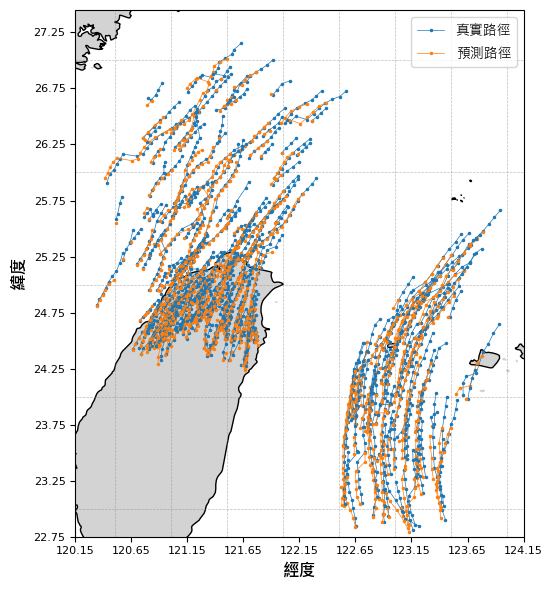

In [36]:
def plot_scit_path(dataset: list) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())  # 經緯度座標系

    # =================== 統計所有經緯度的最大最小值 ===================
    all_lats = []
    all_lngs = []

    for i, data in enumerate(dataset):
        lats = np.array(data[LATITUDE])
        lngs = np.array(data[LONGITUDE])
        all_lats.extend(lats)
        all_lngs.extend(lngs)

        # pred_lats = np.array(data['Pred_Latitude'][2:-1])
        # pred_lngs = np.array(data['Pred_Longitude'][2:-1])
        # all_lats.extend(pred_lats)
        # all_lngs.extend(pred_lngs)

    min_lat, max_lat = min(all_lats), max(all_lats)
    min_lng, max_lng = min(all_lngs), max(all_lngs)

    # =================== 繪圖開始 ===================
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 設定經緯度邊界，加 buffer
    lat_buffer = (max_lat - min_lat) * 0.05
    lng_buffer = (max_lng - min_lng) * 0.05
    # ax.set_extent([min_lng - lng_buffer, max_lng + lng_buffer,
    #                min_lat - lat_buffer, max_lat + lat_buffer], crs=ccrs.PlateCarree())

    # '梅雨鋒面個案_2021-05-30'
    # ax.set_extent([119.8001659, 123.8208661, 23.81446730319214, 26.75911663296509], crs=ccrs.PlateCarree())
    # min_lat, max_lat = 23.45, 26.5
    # min_lng, max_lng = 119.8, 123.8

    # '午後對流個案_2022-08-25'
    # min_lat, max_lat = 23.25, 25.75
    # min_lng, max_lng = 119.75, 122.5
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # print(f'設定經緯度範圍: {extent}')
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    # '烟花颱風個案_2021-07-22'
    min_lat, max_lat = 22.75, 27.45
    min_lng, max_lng = 120.15, 124.15
    extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    print(f'設定經緯度範圍: {extent}')
    ax.set_extent(extent, crs=ccrs.PlateCarree())


    # 設定 X、Y 軸刻度（每隔 0.5 度一格可調整）
    x_ticks = np.round(np.arange(min_lng, max_lng + 0.1, 0.5), 2)
    y_ticks = np.round(np.arange(min_lat, max_lat + 0.1, 0.5), 2)
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)

    # 可選：顯示經緯度刻度線
    ax.gridlines(draw_labels=False, linewidth=0.5,
                 color='gray', alpha=0.5, linestyle='--')

    # =================== 畫實際與預測軌跡 ===================
    for i, data in enumerate(dataset):
        latitudes = list(np.array(data[LATITUDE]))
        longitudes = list(np.array(data[LONGITUDE]))

        pred_latitudes = list(np.array(data['Pred_Latitude'][2:-1]))
        pred_longitudes = list(np.array(data['Pred_Longitude'][2:-1]))

        plt.plot(longitudes, latitudes, marker='o',
                 markersize=1.5, color='#1f77b4', linewidth=.5)
        plt.plot(pred_longitudes, pred_latitudes, marker='o',
                 markersize=1.5, color='#ff7f0e', linewidth=.5)

    plt.legend(['真實路徑', '預測路徑'], prop=jheng_hei_font, fontsize=8)
    # plt.title(f'LSTM 預測路徑', fontproperties=jheng_hei_b_font, fontsize=14)
    plt.xlabel('經度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.ylabel('緯度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.tight_layout()
    plt.show()

dataset, _, _, _ = dataset_components

scit_dataset = create_scit_predict_path(dataset, forecast_seconds=360)

# 評估模型
scit_evaluate(scit_dataset)

plot_scit_path(scit_dataset)